# Dask

#### Dask is a Python library for parallel and distributed computing.
---
### Objectives:
- Profile the timing of the raster calculations.
- Open raster data as a chunked array.
- Recognize good practices in selecting proper chunk sizes.
- Setup raster calculations that take advantage of parallelization.


In [2]:
#import lib
import pystac
items = pystac.ItemCollection.from_file('search.json')

In [3]:
# select the last scene, and extract the URL of the true-color image (“visual”)
assets = items[-1].assets


In [4]:
visual_href = assets["visual"].href #true-color-composite

In [6]:
visual_href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200321_0_L2A/TCI.tif'

In [7]:
#import rxr, load visual, overview level=2
import rioxarray
visual = rioxarray.open_rasterio(visual_href, overview_level=2)
print(visual.rio.resolution())

(79.97086671522214, -79.97086671522214)


In [8]:
visual = visual.load()

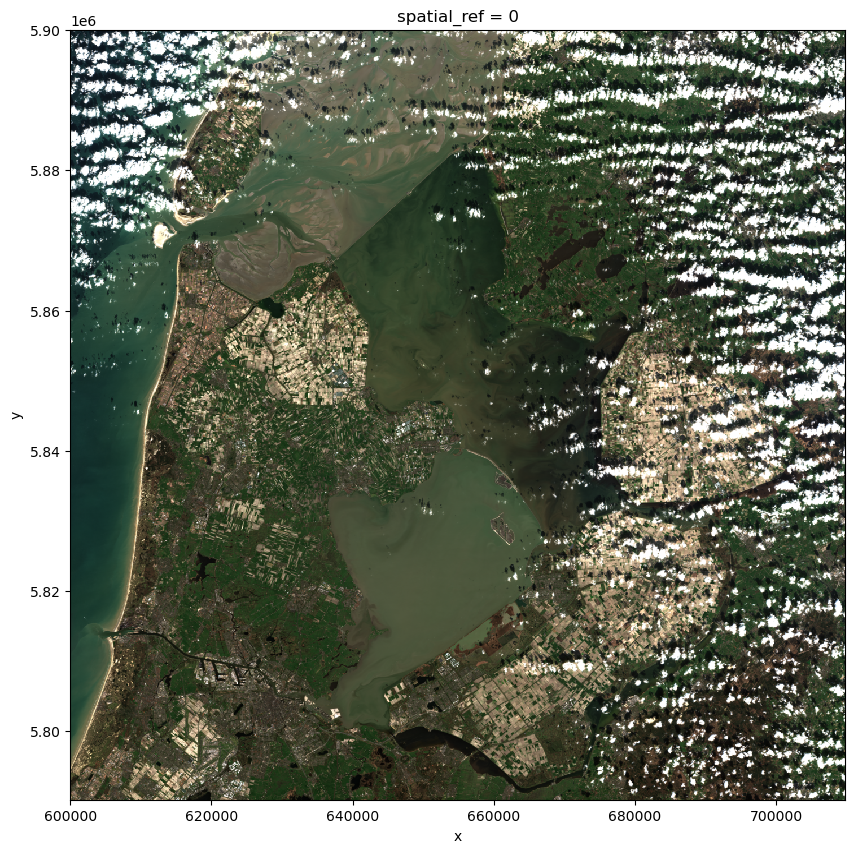

In [9]:
# imshow (10,10)
visual.plot.imshow(figsize=(10,10))

In [11]:
%%time
median = visual.rolling(x=7, y=7, center=True).median()

CPU times: user 8.89 s, sys: 1.28 s, total: 10.2 s
Wall time: 10.2 s


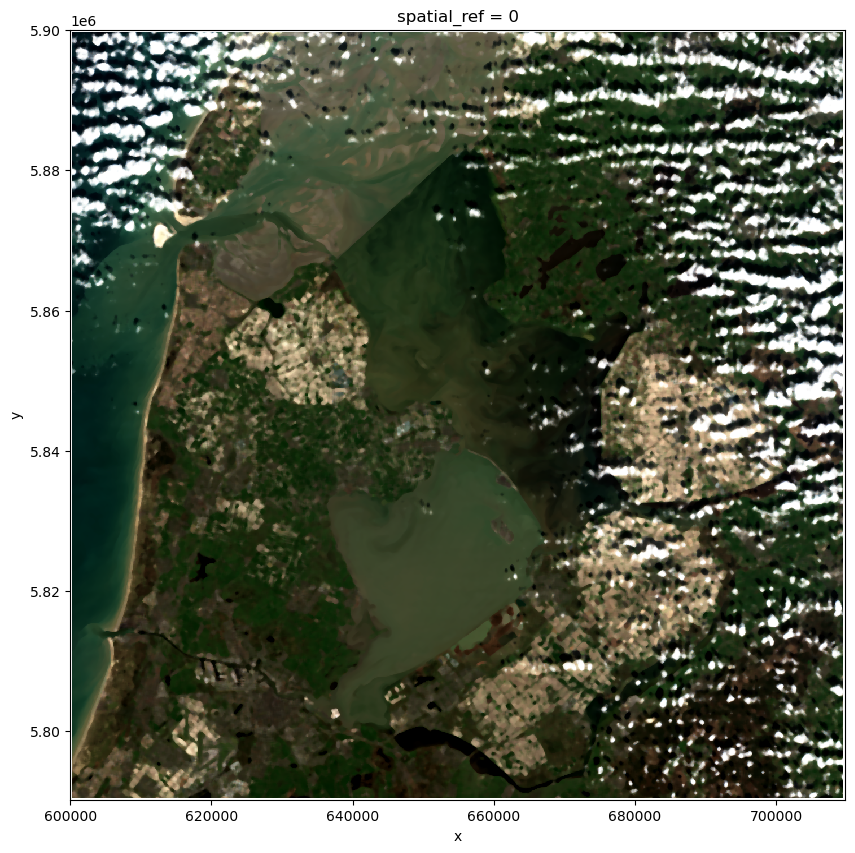

In [12]:
#plot median
median.plot.imshow(robust=True, figsize=(10,10))

In [15]:
#write to disk
median.rio.to_raster("visual_median_filter.tif")

AttributeError: 'DataArray' object has no attribute '_data'

### Chunked Array with Dask

In [16]:
#load blue band with chunks
blue_band_href = assets["blue"].href
blue_band = rioxarray.open_rasterio(blue_band_href, chunks=(1, 4000, 4000))

In [17]:
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-afe10339683e10ebd526a0f1c615efec<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

### Exercise: Chunk Sizes Matter

In [18]:
import rasterio
with rasterio.open(blue_band_href) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")

Chunk size: [(1024, 1024)]


In [20]:
%%time
band = rioxarray.open_rasterio(blue_band_href, chunks="auto")
band

CPU times: user 8.19 ms, sys: 40 µs, total: 8.23 ms
Wall time: 7.57 ms


<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-0b3eaf406cbe17ebfb4304323d0830e7<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [21]:
# parallel computation
visual_dask = rioxarray.open_rasterio(visual_href, overview_level=2, lock=False, chunks=(3, 500, 500))

In [22]:
visual_dask

<xarray.DataArray (band: 3, y: 1373, x: 1373)>
dask.array<open_rasterio-abe441763e5d984636eae153d54175c6<this-array>, shape=(3, 1373, 1373), dtype=uint8, chunksize=(3, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [32]:
# .persist 
visual_dask = visual_dask.persist(scheduler='threads', num_workers=4)

In [33]:
%%time
median_dask = visual_dask.rolling(x=7,y=7, center=True).median()

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.2 ms


In [34]:
# dask graph
import dask
dask.visualize(median_dask)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [35]:
%%time
median_dask.persist(scheduler='threads', num_workers=4)

CPU times: user 12.1 s, sys: 1.37 s, total: 13.5 s
Wall time: 3.43 s


<xarray.DataArray (band: 3, y: 1373, x: 1373)>
dask.array<where, shape=(3, 1373, 1373), dtype=float32, chunksize=(3, 503, 503), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

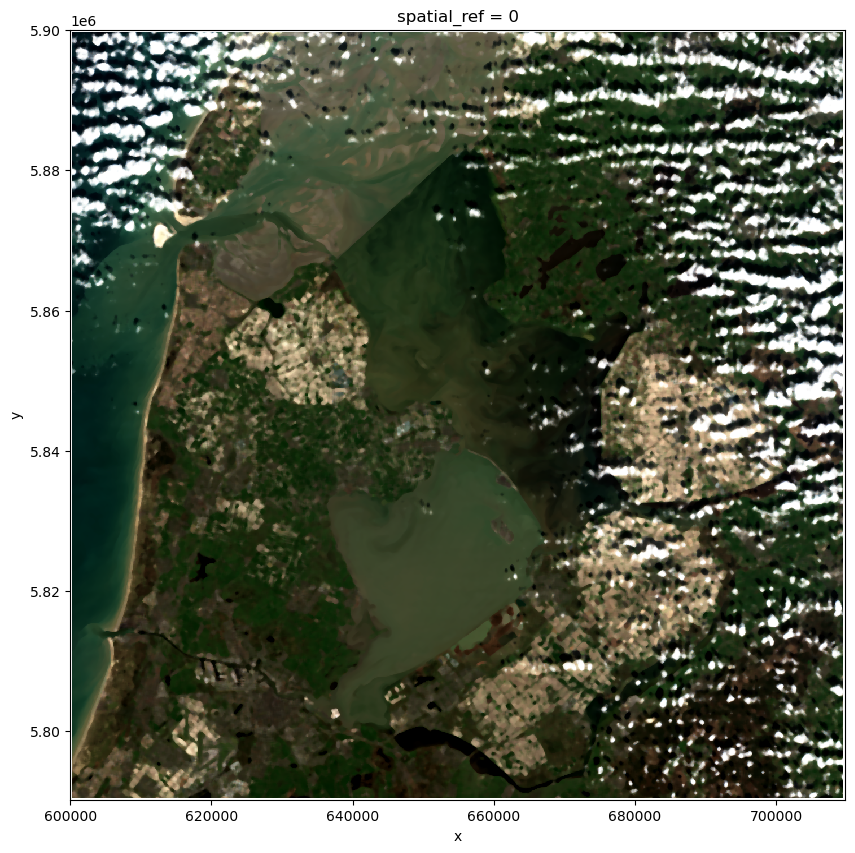

In [36]:
median_dask.plot.imshow(robust=True, figsize=(10,10))

In [ ]:
# write to the disk
from threading import Lock
median_dask.rio.to_raster("visual_median-filter_dask.tif", tiled=True, lock=Lock())